In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import scipy
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from statistics import mean 

In [2]:
FILE_PATH = 'data/pilot5.json'
#pilot 5 has 3 anagrams, subjects are probed about their closeness ratings every 20seconds (press key b/w 0-9)
all_entries = []
with open(FILE_PATH) as file:
    for line in file:
        entry = json.loads(line)
        all_entries.append(entry)
        e = entry['data']
len(all_entries)



212

In [3]:
start = []
finish = []
k = 0
for entry in all_entries:
    if isinstance(entry['data'], dict):
        start.append(entry)
    else:
        if(k==25):            
            pass #don't append the 25th guy, dropped out midway
        else:
            finish.append(entry)
        k = k+1

def return_indices(user_order): #function that searches through the list of anagrams and returns the indices of the anagrams seen by the subject
    order = ['BLEL', 'SROT', 'WROD', 'PITN', 'SONW', 'VLVOO', 'PONHE', 'RECKL', 'SSOIA', 'PREOK', 'YJAKWLA', 'KHAOMCM', 'IORCNAG', 'DALRBEU', 'HNATUYG']
    idx = []
    for i in range(len(user_order)):
        idx.append(order.index(user_order[i]))
    return idx

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    #print(a)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [4]:
#Total of 102 subjects and each saw 3 anagrams -- so total datapoints = 102*3 -- this block analyses the total datapoints individually
#get warmth ratings and aha ratings for all the individual anagrams seen by subjects

outer_counter = 0

close_guess = [[] for i in range(400)]
give_up = []
aha = []
actual_rt = []
anagrams = list()

for entry in finish: 
    #if(outer_counter==25):
        #print(entry)
    entry_data = entry['data']      
    idx = return_indices((entry_data[0]['anagrams_seen'])) #get the indices of the anagrams seen by the subject
    anagrams_answers = entry_data[0]['anagrams_answers']
    close_guess[outer_counter].append(entry_data[5]['key_press']-48) #5 is first warmth estimation
    
    counter = 6    
    attempt = entry_data[6]['responses'] 
    rt = entry_data[6]['rt']
    g = 0
    
    anagrams.append(anagrams_answers[0].lower()) #append the anagram
    
    while anagrams_answers[0].lower() not in attempt.lower(): #keep incrementing until person gets correct answer or gives up
        if "next" in attempt.lower(): #break if person gave up
            g = 1 #subject gave up
            break
        else:                
            counter = counter+1
            close_guess[outer_counter].append(entry_data[counter]['key_press']-48) #closeness rating
            counter = counter+1
            attempt = entry_data[counter]['responses']
            rt = rt+entry_data[counter]['rt']
    
    counter = counter+2
    r = entry_data[counter]['responses'] #aha rating
    aha.append(int(r[6]))
    give_up.append(g) #add if subject gave up or not
    actual_rt.append(rt) #append actual time to complete
    
    outer_counter=outer_counter+1 #move to the next anagram
    
    #next anagram
    counter = counter+3
    close_guess[outer_counter].append(entry_data[counter]['key_press']-48) #closeness rating
    
    counter = counter+1    
    attempt = entry_data[counter]['responses']
    rt = entry_data[counter]['rt']
    
    g = 0
    anagrams.append(anagrams_answers[1].lower()) #append the anagram
    
    while anagrams_answers[1].lower() not in attempt.lower(): #keep incrementing until person gets correct answer or gives up
        if "next" in attempt.lower(): #break if person gave up
            g = 1 #subject gave up
            break
        else:                
            counter = counter+1
            close_guess[outer_counter].append(entry_data[counter]['key_press']-48) #closeness rating
            counter = counter+1
            attempt = entry_data[counter]['responses']
            rt = rt+entry_data[counter]['rt']
            
    counter = counter+2
    r = entry_data[counter]['responses'] #aha rating
    aha.append(int(r[6]))
    give_up.append(g) #add if subject gave up or not
    actual_rt.append(rt) #append actual time to complete
    
    outer_counter=outer_counter+1 #move to the next anagram
    
    #next anagram
    counter = counter+3
    close_guess[outer_counter].append(entry_data[counter]['key_press']-48) #closeness rating
    
    counter = counter+1    
    attempt = entry_data[counter]['responses'] 
    rt = entry_data[counter]['rt']
    
    g = 0
    anagrams.append(anagrams_answers[2].lower()) #append the anagram
    
    while anagrams_answers[2].lower() not in attempt.lower(): #keep incrementing until person gets correct answer or gives up
        if "next" in attempt.lower(): #break if person gave up
            g = 1 #subject gave up
            break
        else:                
            counter = counter+1
            close_guess[outer_counter].append(entry_data[counter]['key_press']-48) #closeness rating
            counter = counter+1
            attempt = entry_data[counter]['responses']
            rt = rt+entry_data[counter]['rt']
            
    counter = counter+2
    r = entry_data[counter]['responses'] #aha rating
    aha.append(int(r[6]))
    give_up.append(g) #add if subject gave up or not
    actual_rt.append(rt) #append actual time to complete
    
    outer_counter=outer_counter+1 #move to the next anagram

In [5]:
#data clean-up and storage here
mean_error = [] #mean warm prediction errors done 
close_guess = [x for x in close_guess if x != []]

last_close = [item[-1] for item in close_guess] #last warmth estimation
first_close = [item[0] for item in close_guess] #first warmth estimation
len_close = [len(item) for item in close_guess] #how long was the person stuck in the problem? 

indexes = [i for i,x in enumerate(give_up) if x == 0] #only get subjects who solved the anagram

aha = np.asarray(aha)
aha = aha[np.asarray(indexes)] 

actual_rt = np.asarray(actual_rt, dtype='float64')*0.001 
actual_rt = actual_rt[np.asarray(indexes)]

last_close = np.asarray(last_close)
last_close = last_close[np.asarray(indexes)] 

first_close = np.asarray(first_close)
first_close = first_close[np.asarray(indexes)] 

len_close = np.asarray(len_close)
len_close = len_close[np.asarray(indexes)] 

#compute mean wpe for each datapoint i.e. how much prediction error people make while solving the anagram? 
for a in close_guess:
    
    a.append(9) #append completed at end of it
    if(len(a)<2):
        mean_error.append(a[0])
    else:        
        cons_diff = [x - a[i - 1] for i, x in enumerate(a)][1:] #get consecutive difference between warm ratings    
        mean_error.append(mean(cons_diff))

mean_error = np.asarray(mean_error)
mean_error = mean_error[np.asarray(indexes)] 
anagrams = [anagrams[i] for i in indexes]

[[ 1.         -0.49469052]
 [-0.49469052  1.        ]]
[[ 1.         -0.47028727]
 [-0.47028727  1.        ]]
[[ 1.         -0.57055521]
 [-0.57055521  1.        ]]
[[1.         0.32196249]
 [0.32196249 1.        ]]
[[1.       0.383562]
 [0.383562 1.      ]]
[[1.         0.93318386]
 [0.93318386 1.        ]]


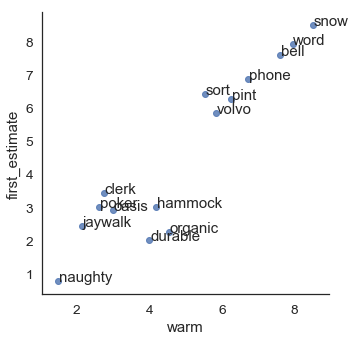

In [9]:
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(style="white", font_scale=1.25)

df = pd.DataFrame({'num': [1]*len(aha), 'first_estimate': first_close, 'rt':actual_rt, 'anagrams': anagrams,'warm': last_close, 'mean_wpe': mean_error,'length': len_close,'aha': aha}) 

df_number = df.groupby(['anagrams']).sum() #number of subjects for each anagram
nums = df_number['num']

df_means = df.groupby(['anagrams']).mean() #means for each anagram
df_means['anagrams'] = list(df_means.index)
print(np.corrcoef(df_means['aha'], df_means['warm'])) #correlate the two
#print(np.corrcoef(df_means['wpe'], nums)) #correlate the two
print(np.corrcoef(df_means['length'], df_means['warm'])) #correlate the two
print(np.corrcoef(df_means['rt'], df_means['warm'])) #correlate the two
print(np.corrcoef(df_means['aha'], df_means['length'])) #correlate the two
print(np.corrcoef(df_means['aha'], df_means['rt'])) #correlate the two
print(np.corrcoef(df_means['warm'], df_means['first_estimate'])) #correlate the two

sns.lmplot('aha', 'warm', data=df_means, fit_reg=False) #plot it
label_point(df_means['aha'], df_means['warm'], df_means['anagrams'] , plt.gca()) 

#sns.lmplot('aha', 'length', data=df_means, fit_reg=False) #plot it
#label_point(df_means['aha'], df_means['length'], df_means['anagrams'] , plt.gca()) 

#sns.lmplot('aha', 'rt', data=df_means, fit_reg=False) #plot it
#label_point(df_means['aha'], df_means['rt'], df_means['anagrams'] , plt.gca()) 

In [96]:
#power analysis
df = pd.DataFrame({'num': [1]*len(aha), 'rt':actual_rt, 'anagrams': anagrams,'warm': last_close, 'mean_wpe': mean_error,'length': len_close,'aha': aha}) 
n = 70
means = []
for i in range(1000):
    df_sample = df.groupby(['anagrams'])['aha', 'warm'].apply(lambda s: s.sample(n, replace=True)) #sample with replacement
    df_means = df_sample.groupby(['anagrams']).mean()
    a = np.corrcoef(df_means['aha'], df_means['warm'])
    means.append(a[1][0])

print(np.mean(means))
print(np.std(means))

-0.4651299082390076
0.08975158139064329


In [10]:
#mediation analysis
from scipy import stats
import statsmodels.api as sm
import math

all_predictors = ['warm', 'rt']
X = df[all_predictors]
y = df['aha']
X = sm.add_constant(X)

linear_model = sm.OLS(y, X)
results = linear_model.fit()
predictions = results.predict(X)
print(results.summary())

ImportError: cannot import name 'factorial'